# Kuramoto-Sivashinsky Quasiperiodic Circular Coordinates

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.io as sio
from scipy import sparse 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
from persim import plot_diagrams, wasserstein
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from gtda.diagrams import PairwiseDistance # For Bottleneck / Wasserstein
from dreimac import CircularCoords
import os
import warnings
warnings.filterwarnings('ignore')

Load in full resolution data and subsample by a factor of 10

In [3]:
def get_random_samples(X, n_samples):
    """
    Sample every time series with samples chosen uniformly at
    random and sorted
    
    Parameters
    ----------
    X: ndarray(N, T)
        N time series, each of length T
    n_samples: int
        Number of samples to take in each time series
    
    Returns
    -------
    locs: ndarray(N, n_samples)
        Sample locations for each time series on the interval [0, 1]
    Y: ndarray(N, n_samples)
        Samples
    """
    Y = np.zeros((X.shape[0], n_samples))
    locs = np.random.rand(X.shape[0], n_samples)
    locs = np.sort(locs, axis=1)
    idx = np.linspace(0, 1, X.shape[1])
    for i in range(X.shape[0]):
        Y[i, :] = np.interp(locs[i, :], idx, X[i, :])
    return locs, Y

In [4]:
np.random.seed(0)
res = sio.loadmat("KS_1_2_0.002.mat")
locs, X = get_random_samples(res['data'], 1000)
#plot_data(locs, X)
print(X.shape)

(500, 1000)


In [5]:
def do_sublevelset_filtration(x):
    """
    Do a sublevelset filtration of a time series using an interval graph
    
    Parameters
    ----------
    x: ndarray(N)
        The time series
    
    Returns
    -------
    dgm: 0D persistence diagram, excluding the essential class
    """
    N = x.size
    # Add edges between adjacent points in the time series, with the "distance" 
    # along the edge equal to the max value of the points it connects
    I = np.arange(N-1)
    J = np.arange(1, N)
    I, J = np.concatenate((I, J)), np.concatenate((J, I))
    V = np.maximum(x[I], x[J])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    dgm = ripser(D, distance_matrix=True, maxdim=0)['dgms'][0]
    #return dgm[np.isfinite(dgm[:, 1]), :]
    return dgm

## Example Sublevelset Filtration w/wo Circular



In [6]:
i = 5
x = X[i, :]
loc = locs[i, :]
dgm1 = do_sublevelset_filtration(x)

print("Interval")
print(dgm1)

Interval
[[ 1.44158363  3.58258152]
 [-7.69628906  6.11502266]
 [-8.34801388  6.53984261]
 [-8.56524849         inf]]


In [7]:
x[x == dgm1[0,1]]

array([], dtype=float64)

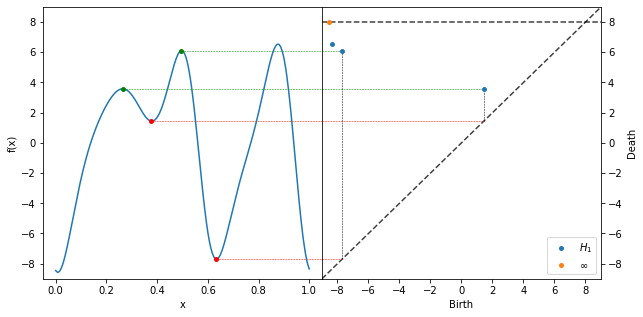

In [11]:
from matplotlib import gridspec
plt.figure(figsize=(10, 5))
#gs1 = gridspec.GridSpec(2, 2)
#gs1.update(wspace=None, hspace=0.0) 

plt.subplot(121)
plt.plot(loc, x)
plt.xlim([-0.05, 1.05])
plt.ylim([-9, 9])
plt.xlabel('x')
plt.ylabel('f(x)')

plt.scatter([0.63275, 0.377],[-7.696, 1.44], c = 'red', s=15, zorder = 10)
plt.scatter([0.265, 0.495],[ 3.586, 6.115], c = 'green', s=15, zorder = 10)

# birth horizontal lines
plt.plot([0.377,10],[1.44, 1.44], 'k--', zorder=0, c = 'red', linewidth = 0.5)
plt.plot([0.63275,10],[-7.69, -7.69],'k--',zorder=0, c = 'red', linewidth = 0.5)

# death horizontal lines
plt.plot([0.265,10],[3.586, 3.586],'k--', zorder=0, c = 'green', linewidth = 0.5)
plt.plot([0.495,10],[6.115,6.115],'k--',zorder=0, c = 'green', linewidth = 0.5)

ax2 = plt.subplot(122)
ax2.set_xlim([-9, 9])
ax2.set_ylim([-9, 9])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax2.scatter(dgm1[:,0],dgm1[:,1], s = 15, label = '$H_1$')
ax2.scatter([-8.565],[8], s = 15, label = '$\infty$')
ax2.set_title('')
ax2.legend(loc = 4)
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

ax2.plot(lims, [8,8], 'k--', alpha=0.75, zorder=0)
ax2.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

ax2.set_ylabel('Death')
ax2.set_xlabel('Birth')

# birth horizontal lines
ax2.plot([-10,1.44],[1.44, 1.44], 'k--', zorder=0, c = 'red', linewidth = 0.5)
ax2.plot([-10,-7.69],[-7.69, -7.69],'k--',zorder=0, c = 'red', linewidth = 0.5)

# death horizontal lines
ax2.plot([-10,1.44],[3.586, 3.586],'k--', zorder=0, c = 'green', linewidth = 0.5)
ax2.plot([-10,-7.69],[6.115,6.115],'k--',zorder=0, c = 'green', linewidth = 0.5)

# feature vertical lines
ax2.plot([1.44,1.44],[1.44, 3.586],'k--', zorder=0, c = 'black', linewidth = 0.5)
ax2.plot([-7.69,-7.69],[-7.69,6.115],'k--',zorder=0, c = 'black', linewidth = 0.5)

#plt.suptitle('Sublevel Set Filtration')
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('sublevelsetfiltration_ex.png')

## Show example of filtration

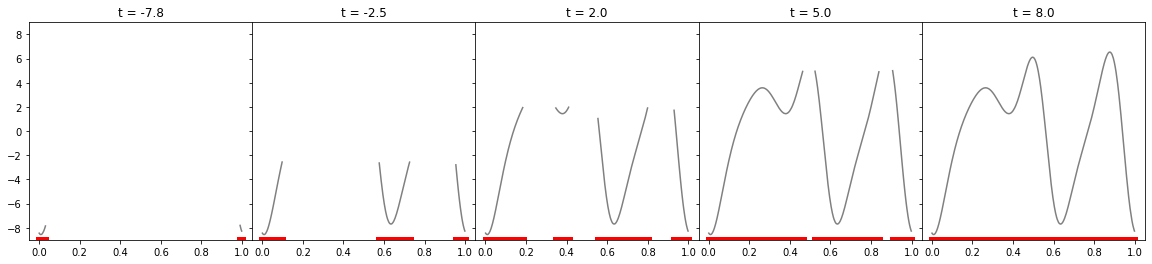

In [9]:
fig, axs = plt.subplots(1,5, figsize = (20,4))
#gs1 = gridspec.GridSpec(1,5)
#gs1.update(wspace=0.025, hspace=0.00)

threshs = [-7.8,-2.5,2.,5.,8.]

for i in range(len(axs)):
    # get the segments 
    thresh = threshs[i]
    idxs = np.arange(len(loc))
    s = idxs[x < thresh]

    intervals = []
    begin = 0
    for j in range(len(s)-1):
        if s[j] < s[j+1] -1:
            end = s[j]
            intervals.append((begin,end))
            begin = s[j+1]
    intervals.append((begin,len(idxs)-1))
    
    axs[i].set_xlim([-0.05, 1.05])
    axs[i].set_ylim([-9, 9])
    axs[i].set_title("t = {:.1f}".format(thresh) )
    
    if i > 0:
        axs[i].set_yticklabels([])

    for l,r in intervals:
        axs[i].plot(loc[l:r],x[l:r], c = 'gray')
        axs[i].plot(loc[l:r],np.zeros_like(loc[l:r]) - axs[i].get_ylim()[1], c = 'red', linewidth = 7, zorder = 0)


# ax = axs[-1]

# ax.set_xlim([-9, 9])
# ax.set_ylim([-9, 9])
# ax.yaxis.set_label_position("right")
# ax.yaxis.tick_right()

# ax.scatter(dgm1[:,0],dgm1[:,1], s = 15, label = 'H1')
# ax.scatter([-8.565],[8], s = 15, label = 'inf')
# ax.set_title('Persistence Diagram')
# ax.legend(loc = 4)
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# ax.plot(lims, [8,8], 'k--', alpha=0.75, zorder=0)
# ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

# ax.set_ylabel('Death')
# ax.set_xlabel('Birth')

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('sublevelsetfiltration.png')